# **Imports and Setting Up**

In [5]:
# Library Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import t
from statsmodels.stats.anova import anova_lm

In [6]:
# File Imports
crops_data = pd.read_csv("https://raw.githubusercontent.com/vaiiishhh/Econometrics/refs/heads/main/ECO221_Project_2025_Final.csv")
rainfall_data = pd.read_csv("https://raw.githubusercontent.com/vaiiishhh/Econometrics/refs/heads/main/RF_DistrictWise_ECO221_2025.csv")
soil_data = pd.read_csv("https://raw.githubusercontent.com/vaiiishhh/Econometrics/refs/heads/main/Salinity_Alkalinity_ECO221_2025.csv")

In [7]:
# Narrowing data to what concerns us
rice_data = crops_data[crops_data["crop"] == "Rice"]
rice_states = rice_data["statename"].unique()
rice_rainfall_data = rainfall_data[rainfall_data["state"].isin(rice_states)]

In [8]:
#@title Data Cleaning Function
corrections = {
        'Ahmedabad': 'Ahmadabad',
        'Almorah': 'Almora',
        'Amarawati': 'Amravati',
        'Ananthapur': 'Anantapur',
        'Allahabad': 'Prayagraj',
        'Banaskantha': 'Banas Kantha',
        'Bangalore': 'Bengaluru Urban',
        'Bhatinda': 'Bathinda',
        'Buland Shahar': 'Bulandshahr',
        'Dangs': 'Dang',
        'Bijapur / Vijayapura': 'Bijapur',
        'Gulbarga / Kalaburagi': 'Gulbarga',
        'Kodagu / Coorg': 'Kodagu',
        'Mahendragarh / Narnaul': 'Mahendragarh',
        'North Arcot / Vellore': 'Vellore',
        'Santhal Paragana / Dumka': 'Santhal Paragana',
        'Seoni / Shivani': 'Seoni',
        'South Arcot / Cuddalore': 'Cuddalore',
        'Vadodara / Baroda': 'Vadodara',
        'Tiruchirapalli / Trichy': 'Tiruchirapalli',
        'Roopnagar / Ropar': 'Ropar',
        'Shahabad (now part of Bhojpur district)': 'Bhojpur',
        'Gurgaon': 'Gurugram',
        'Hissar': 'Hisar',
        'Mysore': 'Mysuru',
        'Faizabad': 'Ayodhya',
        'Kanpur': 'Kanpur Nagar',
        'Champaran': 'Purbi Champaran',
        'Garhwal': 'Pauri Garhwal',
        'Singhbhum': 'West Singhbhum',
        'Mungair': 'Munger',
        'Santhal Paragana': 'Dumka',
        'Palamau': 'Palamu',
        'Rae-Bareily': 'Rae Bareli',
        'Pithorgarh': 'Pithoragarh',
        'Lahul & Spiti': 'Lahaul and Spiti',
        'Sabarkantha': 'Sabar Kantha',
        'Swami Madhopur': 'Sawai Madhopur',
        'Ropar': 'Rupnagar',
        'Ferozpur': 'Firozpur',
        'Ramananthapuram': 'Ramanathapuram',
        'Thirunelveli': 'Tirunelveli',
        'Kanyakumari': 'Kanniyakumari',
        'Gulbarga': 'Kalaburagi',
        'Belgaum': 'Belagavi',
        'Bellary': 'Ballari',
        'Tumkur': 'Tumakuru',
        'S.P.S. Nellore': 'Nellore',
        'Kadapa YSR': 'YSR Kadapa',
        'Nellore': 'Spsr Nellore',
        'YSR Kadapa': 'Y.S.R.',
        'Tiruchirapalli': 'Tiruchirappalli',
        'Firozpur': 'Ferozepur',
        'Lahul & Spiti': 'Lahul And Spiti',
        'Lahul &amp; Spiti': 'Lahul And Spiti',
        "Visakhapatnam": 'Visakhapatanam',
        'Warangal Rural': "Warangal",
        "Warangal Urban": "Warangal",
        "SPSR Nellore": "Spsr Nellore",
        "Firozepur": "Ferozepur"}

def standardize_districts(rice_data, rainfall_data_yearly, rainfall_data_seasonal):
  rice_df = rice_data.copy()
  rainfall_df = rainfall_data_yearly.copy()
  rainfall_df_kharif = rainfall_data_seasonal.copy()
  for old_name, new_name in corrections.items():
      rice_df.loc[rice_df['districtname'] == old_name, 'districtname'] = new_name
  for old_name, new_name in corrections.items():
      rainfall_df.loc[rainfall_df['district'] == old_name, 'district'] = new_name
  for old_name, new_name in corrections.items():
      rainfall_df_kharif.loc[rainfall_df_kharif['district'] == old_name, 'district'] = new_name
  return rice_df, rainfall_df, rainfall_df_kharif

# **Merging Crops Data with Rainfall Data**

In [9]:
# Task 1

# 1. Taking both yearly and seasonal rainfall per district
rice_rainfall_data_yearly = rice_rainfall_data.groupby('district', as_index=False)['rf'].mean()
rice_rainfall_data_kharif = rice_rainfall_data[rice_rainfall_data["monthcode"].isin([201706, 201707, 201708, 201709, 201710])].groupby('district', as_index=False)['rf'].mean()

# 2. Streamlining district names
rice_data, rice_rainfall_data_yearly, rice_rainfall_data_kharif = standardize_districts(rice_data, rice_rainfall_data_yearly, rice_rainfall_data_kharif)
rice_districts = rice_districts = (rice_data['districtname'].unique())

# # # 3. Merge the rainfall columns to rice_data district wise
rice_data = pd.merge(rice_data, rice_rainfall_data_yearly, left_on='districtname', right_on='district', how='left')
rice_data = rice_data.rename(columns = {"rf" : "rf_yearly"})
rice_data = pd.merge(rice_data, rice_rainfall_data_kharif, left_on='districtname', right_on='district', how='left')
rice_data = rice_data.rename(columns = {"rf" : "rf_seasonal"})

# # 4. Droping/renaming the extra columns that were added during the merges
rice_data = rice_data.drop(columns=['district_x', 'district_y'])

# **Merging with Salinity-Alkanity Data**

In [10]:
# Task 2

# 1. Streamlining district names
for old_name, new_name in corrections.items():
      soil_data.loc[soil_data['District Name'] == old_name, 'District Name'] = new_name

# 2. Aggregating data for Warangal
warangal_data = soil_data[soil_data['District Name'] == 'Warangal'].sum()
warangal_data['District Name'] = 'Warangal'
soil_data = soil_data[soil_data['District Name'] != 'Warangal']
soil_data = pd.concat([soil_data, pd.DataFrame(warangal_data).T], ignore_index=True)

# 3. Merge into rice_data district wise
rice_data = pd.merge(rice_data, soil_data, left_on='districtname', right_on='District Name', how='left')

# 4. Droping/renaming the extra columns that were added during the merges
rice_data = rice_data.drop(columns=['District Name'])
rice_data = rice_data.rename(columns= {"Average Salinity/Alkalinity (Percentage)": "salinity_alkalinity_index"})

# 5. Salinity_alkanity was read a string
rice_data['salinity_alkalinity_index'] = rice_data['salinity_alkalinity_index'].astype(float)

# **1. Summary Statistics**

### 1.1 Identifying and Dealing with Missing Values

Agricultural production variables had 26 missing entries each (approximately 9.8% of the dataset):



*   area1000hectares
*   production1000tonnes
*   irrigatedarea1000hectares

Rainfall variables had 3 missing entries each (1.1% of the dataset):

* rf_yearly
* rf_seasonal

Salinity_index variables had 1 missing entry:

Implemented appropriate imputation strategies:

* State-wise average imputation for agricultural variables, which preserves regional production patterns

* K-nearest neighbors imputation (n_neighbors=3) for rainfall data, which better accounts for spatial patterns than simple averages

The imputation process was completed successfully, with verification showing zero missing values remaining across all variables.

In [11]:
missing_entries = rice_data.isnull().sum()
missing_entries

crop                           0
area1000hectares              26
production1000tonnes          26
irrigatedarea1000hectares     26
districtcode                   0
year                           0
statecode                      0
statename                      0
nitrogenconsumptiontonnes      0
phosphateconsumptiontonnes     0
potashconsumptiontonnes        0
districtname                   0
rf_yearly                      4
rf_seasonal                    4
salinity_alkalinity_index      1
dtype: int64

In [12]:
# Using state-wise avg for filling null values in area and production
for col in ['area1000hectares', 'production1000tonnes', 'irrigatedarea1000hectares', 'salinity_alkalinity_index']:
    rice_data[col] = rice_data.groupby('statename')[col].transform(lambda x: x.fillna(x.mean()))

# Using k-nearest neighbur for filling in missing rainfall data
imputer = KNNImputer(n_neighbors=3)
rainfall_cols = ['rf_yearly', 'rf_seasonal']
rice_data[rainfall_cols] = imputer.fit_transform(rice_data[rainfall_cols])

missing_entries = rice_data.isnull().sum()
missing_entries

crop                          0
area1000hectares              0
production1000tonnes          0
irrigatedarea1000hectares     0
districtcode                  0
year                          0
statecode                     0
statename                     0
nitrogenconsumptiontonnes     0
phosphateconsumptiontonnes    0
potashconsumptiontonnes       0
districtname                  0
rf_yearly                     0
rf_seasonal                   0
salinity_alkalinity_index     0
dtype: int64

### 1.2 Identifying and dealing with values == 0 for non-environmental variables

* 42 districts (15.8% of observations) reported zero irrigated area
* All other key numerical variables had no zero values

This required special handling since:
* Zero irrigated area likely represents rainfed farming systems
* Log transformation in Cobb-Douglas function cannot handle zeros

Added 1 to all irrigated area values to enable logarithmic transformation

In [13]:
zero_counts = {}
for col in ['area1000hectares', 'production1000tonnes', 'irrigatedarea1000hectares', 'nitrogenconsumptiontonnes', 'phosphateconsumptiontonnes', 'potashconsumptiontonnes', "unirrigatedarea1000hectares"]:
    if col in rice_data.columns:
        zero_counts[col] = (rice_data[col] == 0.0).sum()

print("\nCount of zero values in key variables:")
print(pd.Series(zero_counts))


Count of zero values in key variables:
area1000hectares               0
production1000tonnes           0
irrigatedarea1000hectares     42
nitrogenconsumptiontonnes      0
phosphateconsumptiontonnes     0
potashconsumptiontonnes        0
dtype: int64


In [14]:
rice_data['irrigatedarea1000hectares'] = (rice_data['irrigatedarea1000hectares']+1)

### 1.3 Ensuring Irrigated Area is capped at Total Cropped Area

* 107 districts (40.2% of observations) had reported irrigated area exceeding total cropped area

* This logical inconsistency was corrected by capping irrigated area at (total area - 1)

* After correction, no instances of irrigated area exceeding total area remain

In [15]:
count = 0;
for index, row in rice_data.iterrows():
  if row['irrigatedarea1000hectares'] > row['area1000hectares']:
    count += 1
print(count)

for index, row in rice_data.iterrows():
  if row['irrigatedarea1000hectares'] > row['area1000hectares']:
    rice_data.loc[index, 'irrigatedarea1000hectares'] = (row['area1000hectares'])

count = 0;
for index, row in rice_data.iterrows():
  if row['irrigatedarea1000hectares'] > row['area1000hectares']:
    count += 1
print(count)

107
0


### 1.4 Adding Unrrigated Area col in rice_data
nirrigatedarea1000hectares= area1000hectares - irrigatedarea1000hectares




In [16]:
rice_data["unirrigatedarea1000hectares"] = rice_data["area1000hectares"] - rice_data["irrigatedarea1000hectares"] + 1

In [17]:
zero_counts = {}
for col in ['area1000hectares', 'production1000tonnes', 'irrigatedarea1000hectares', 'nitrogenconsumptiontonnes', 'phosphateconsumptiontonnes', 'potashconsumptiontonnes', "unirrigatedarea1000hectares"]:
    if col in rice_data.columns:
        zero_counts[col] = (rice_data[col] == 0.0).sum()

print("\nCount of zero values in key variables:")
print(pd.Series(zero_counts))


Count of zero values in key variables:
area1000hectares               0
production1000tonnes           0
irrigatedarea1000hectares      0
nitrogenconsumptiontonnes      0
phosphateconsumptiontonnes     0
potashconsumptiontonnes        0
unirrigatedarea1000hectares    0
dtype: int64


### 1.5 Summary of numeric data

- **Area & Production**
  - The average district cultivates **126.7 thousand hectares** of rice, producing **343.8 thousand tonnes**.
  - There is **very high variability** (area std dev: 151.7; production std dev: 438.6).
  - Districts range from as small as **0.01 thousand hectares** to as large as **959 thousand hectares**.
  - Production ranges from **0.02 to 2726.6 thousand tonnes**, indicating a wide disparity in district productivity.

- **Irrigation & Unirrigated Area**
  - Mean irrigated area is **78.9 thousand hectares**, ranging from **0.01** to **641 thousand hectares**.
  - The large spread (std dev: 111.4) and low minimum suggest many districts rely mainly on rainfed agriculture, while a few are highly irrigated.
  - Mean unirrigated area is **47.8 thousand hectares** (std dev: 99.2), with a maximum of **627.3** and minimum of **0**, confirming the diversity in irrigation coverage.

- **Fertilizer Use**
  - **Nitrogen**: Mean 54,250 tonnes (std dev: 45,474; max: 294,303).
  - **Phosphate**: Mean 21,348 tonnes (std dev: 16,680; max: 93,574).
  - **Potash**: Mean 7,635 tonnes (std dev: 9,521; max: 74,158).
  - These large ranges reflect substantial differences in input intensity across districts.

- **Rainfall**
  - **Annual rainfall** averages **73.5 mm** (std dev: 52.3; range: 0.25–376.7 mm).
  - **Seasonal rainfall** is higher, with a mean of **153 mm** (std dev: 114.8; max: 873.9 mm).
  - This highlights the diverse climatic conditions across rice-growing districts.

- **Soil Salinity/Alkalinity**
  - The index averages **11.7** (std dev: 20.4), with some districts near zero and others as high as **96.6**, indicating serious soil quality issues in certain areas.


In [18]:
numeric_summary = rice_data.describe(include='number').T
numeric_summary

,count,mean,std,min,25%,50%,75%,max
area1000hectares,266.0,126.698115,151.695884,0.01,14.665384,79.472221,181.735003,959.010010
production1000tonnes,266.0,343.883533,438.613264,0.02,34.231732,191.240002,474.795005,2726.580100
irrigatedarea1000hectares,266.0,78.869359,111.449105,0.01,3.075000,33.003999,111.300500,641.060000
districtcode,266.0,220.398496,241.947646,1.00,69.750000,144.500000,220.750000,917.000000
year,266.0,2017.000000,0.000000,2017.00,2017.000000,2017.000000,2017.000000,2017.000000
statecode,266.0,9.545113,5.158601,1.00,6.000000,10.000000,12.000000,20.000000
nitrogenconsumptiontonnes,266.0,54249.699248,45474.228372,75.00,21172.500000,44017.000000,77084.500000,294303.000000
phosphateconsumptiontonnes,266.0,21347.951128,16680.325268,33.00,8920.500000,18456.000000,30641.500000,93574.000000
potashconsumptiontonnes,266.0,7634.819549,9520.873518,2.00,1489.750000,4383.500000,10182.000000,74158.000000
rf_yearly,266.0,73.499607,52.343809,0.25,50.484376,65.753160,79.770625,376.686667


### 1.6 Summary of Categorical Data

  - There are **18 unique states** in the data.
  
  - **Uttar Pradesh** is the most represented, with **45 districts**, indicating a regional concentration of rice cultivation.

  - All **266 district names** are unique (no duplicates), ensuring that each row represents a distinct district.

In [19]:
categorical_summary = rice_data.describe(include='object').T
categorical_summary

,count,unique,top,freq
crop,266,1,Rice,266
statename,266,18,Uttar Pradesh,45
districtname,266,266,Durg,1


# **2. Cobb-Douglas Production Function**

## 2.1 Taking log of non-envi vars

In [20]:
non_env_vars = [
    'area1000hectares',
    'irrigatedarea1000hectares',
    'nitrogenconsumptiontonnes',
    'phosphateconsumptiontonnes',
    'potashconsumptiontonnes',
    'unirrigatedarea1000hectares'
]

for var in non_env_vars:
    log_col = f'log_{var}'
    rice_data[log_col] = np.log(rice_data[var].replace(0, np.nan))

rice_data['log_production1000tonnes'] = np.log(rice_data['production1000tonnes'].replace(0, np.nan))

rice_data


,crop,area1000hectares,production1000tonnes,irrigatedarea1000hectares,districtcode,year,statecode,statename,nitrogenconsumptiontonnes,phosphateconsumptiontonnes,...,rf_seasonal,salinity_alkalinity_index,unirrigatedarea1000hectares,log_area1000hectares,log_irrigatedarea1000hectares,log_nitrogenconsumptiontonnes,log_phosphateconsumptiontonnes,log_potashconsumptiontonnes,log_unirrigatedarea1000hectares,log_production1000tonnes
0,Rice,841.130000,983.21002,353.733000,1,2017,14,Chhattisgarh,91447,53486,...,168.366000,0.000000,488.397000,6.734746,5.868542,11.423515,10.887175,9.740557,6.191129,6.890823
1,Rice,660.359990,801.82001,33.077999,2,2017,14,Chhattisgarh,21279,12584,...,176.925998,0.000000,628.281991,6.492785,3.498868,9.965476,9.440181,8.359603,6.442989,6.686884
2,Rice,959.010010,1520.95000,525.374020,3,2017,14,Chhattisgarh,92008,47721,...,133.599998,0.000000,434.635990,6.865902,6.264110,11.429631,10.773127,9.619399,6.074509,7.327090
3,Rice,727.940000,1295.71000,400.825010,4,2017,14,Chhattisgarh,72926,29713,...,155.783002,0.390813,328.114990,6.590219,5.993525,11.197201,10.299340,8.841448,5.793364,7.166814
4,Rice,411.120000,623.28998,54.150002,5,2017,14,Chhattisgarh,31282,13620,...,117.514000,0.000000,357.969998,6.018885,3.991758,10.350798,9.519295,8.217978,5.880449,6.435012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Rice,266.019990,533.69000,1.266000,913,2017,15,Jharkhand,15376,11091,...,252.012004,0.000000,265.753990,5.583571,0.235862,9.640563,9.313889,7.303843,5.582571,6.279815
262,Rice,53.279999,113.46000,1.019000,914,2017,15,Jharkhand,427,297,...,220.674004,0.000000,53.260999,3.975561,0.018822,6.056784,5.693732,4.406719,3.975204,4.731450
263,Rice,121.890000,253.28000,45.990002,915,2017,15,Jharkhand,16063,8959,...,157.571998,0.000000,76.899998,4.803119,3.828424,9.684274,9.100414,7.439559,4.342506,5.534496
264,Rice,556.330020,1124.50000,5.186000,916,2017,15,Jharkhand,28893,20374,...,255.110002,0.000000,552.144020,6.321362,1.645963,10.271355,9.922015,8.281218,6.313809,7.025094


## 2.2 Cobb-Douglas

In [21]:
#Cobb-Douglas regression including rf_seasonal
formula = (
    'log_production1000tonnes ~ '
    'log_irrigatedarea1000hectares + '
    'log_unirrigatedarea1000hectares + '
    'log_nitrogenconsumptiontonnes + '
    'log_phosphateconsumptiontonnes + '
    'log_potashconsumptiontonnes + '
    'rf_seasonal + salinity_alkalinity_index'
)

model_A = smf.ols(formula, data=rice_data).fit()
print(model_A.summary())

                               OLS Regression Results                               
Dep. Variable:     log_production1000tonnes   R-squared:                       0.847
Model:                                  OLS   Adj. R-squared:                  0.843
Method:                       Least Squares   F-statistic:                     204.2
Date:                      Wed, 25 Jun 2025   Prob (F-statistic):          2.34e-101
Time:                              12:00:45   Log-Likelihood:                -353.01
No. Observations:                       266   AIC:                             722.0
Df Residuals:                           258   BIC:                             750.7
Df Model:                                 7                                         
Covariance Type:                  nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

# **3. Outliers, Influential Observations & Correlation Analysis**

## 3.1 Outliers and Influential Variables
Identified outliers using standardized residuals (|std_residual| > 3) and influential points using Cook’s D (> 4/n), DFBETAs, DFFITs . After removing these points, I re-estimated the model.

**Results:** Removing outliers led to a stronger, more explanatory model (higher R-squared, Adj. R-squared, F-statistic), with lower variances, but at the cost of a reduced sample size

There was no clear evidence that these points were due to data entry or measurement errors. Therefore, outliers were retained in the main analysis to accurately reflect real-world variability. Both sets of results are presented to ensure transparency and robustness of findings.

In [22]:
# Recognizing Outliers and Influential points
influence = model_A.get_influence()
influence_df = influence.summary_frame()

outliers = influence_df[abs(influence_df['standard_resid']) > 3]
print("Outlier indices (|standardized residual| > 3):", outliers.index.tolist())

n = len(influence_df)
influential_points = influence_df[influence_df['cooks_d'] > 4/n]
print("Influential point indices (Cook's D > 4/n):", influential_points.index.tolist())

Outlier indices (|standardized residual| > 3): [98]
Influential point indices (Cook's D > 4/n): [0, 2, 31, 39, 60, 89, 90, 91, 93, 98, 99, 100, 101, 102, 105, 106, 108, 110, 111, 119, 258, 261, 262, 265]


In [23]:
X = rice_data[['log_irrigatedarea1000hectares','log_unirrigatedarea1000hectares','log_nitrogenconsumptiontonnes','log_phosphateconsumptiontonnes','log_potashconsumptiontonnes', 'rf_seasonal','salinity_alkalinity_index']]

# DFBETAs
dfbetas = influence.dfbetas
dfbetas_df = pd.DataFrame(dfbetas, columns=['Intercept'] + X.columns.tolist())

# DFFITS
dffits, _ = influence.dffits
dffits_series = pd.Series(dffits)


In [24]:
n = X.shape[0]
k = X.shape[1]

# Thresholds
dfbeta_threshold = 2 / np.sqrt(n)
dffits_threshold = 2 * np.sqrt(k / n)

# Influential observations based on DFBETAs
influential_dfbeta = (dfbetas_df.abs() > dfbeta_threshold).any(axis=1)
print("\nInfluential DFBETAs indices:", dfbetas_df[influential_dfbeta].index.tolist())

# Influential observations based on DFFITS
influential_dffits = dffits_series.abs() > dffits_threshold
print("\nInfluential DFFITS indices:", dffits_series[influential_dffits].index.tolist())



Influential DFBETAs indices: [0, 2, 3, 7, 13, 14, 31, 39, 60, 69, 71, 85, 89, 90, 91, 92, 93, 95, 98, 99, 100, 101, 102, 105, 106, 108, 109, 110, 111, 114, 115, 116, 118, 119, 126, 127, 128, 129, 137, 154, 158, 160, 161, 162, 168, 192, 193, 203, 226, 231, 232, 234, 235, 239, 250, 251, 252, 258, 261, 262, 264, 265]

Influential DFFITS indices: [0, 2, 31, 39, 60, 89, 90, 91, 93, 98, 99, 100, 101, 102, 105, 106, 108, 110, 111, 119, 127, 258, 261, 262, 265]


In [25]:
indices_to_remove = dfbetas_df[influential_dfbeta & influential_dffits].index.tolist()
# rice_data.loc[indices_to_remove, :]

In [26]:
# Removing outliers and regressing
rice_data_clean = rice_data.drop(index=indices_to_remove)
X_clean = rice_data_clean[['log_irrigatedarea1000hectares',
                           'log_unirrigatedarea1000hectares',
                           'log_nitrogenconsumptiontonnes',
                           'log_phosphateconsumptiontonnes',
                           'log_potashconsumptiontonnes',
                           'rf_seasonal',
                           'salinity_alkalinity_index']]
X_clean = sm.add_constant(X_clean)
y_clean = rice_data_clean['log_production1000tonnes']

model_clean = sm.OLS(y_clean, X_clean).fit()
print("\nModel summary without outliers/influential points:")
print(model_clean.summary())


Model summary without outliers/influential points:
                               OLS Regression Results                               
Dep. Variable:     log_production1000tonnes   R-squared:                       0.915
Model:                                  OLS   Adj. R-squared:                  0.912
Method:                       Least Squares   F-statistic:                     357.7
Date:                      Wed, 25 Jun 2025   Prob (F-statistic):          8.46e-121
Time:                              12:00:45   Log-Likelihood:                -229.12
No. Observations:                       241   AIC:                             474.2
Df Residuals:                           233   BIC:                             502.1
Df Model:                                 7                                         
Covariance Type:                  nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975

## 3.2 Correlation Diagnostics
- The original model showed high multicollinearity, especially among fertilizer variables (nitrogen, phosphate, potash).
- Combined the fertilizer variables into a single NPK_index to address multicollinearity.
- The heatmap now shows all pairwise correlations among predictors are low
- Despite low pairwise correlations, the model still shows a high condition number.
- The remaining high condition number is likely due to scaling or numerical factors and does not indicate a problem with the model.

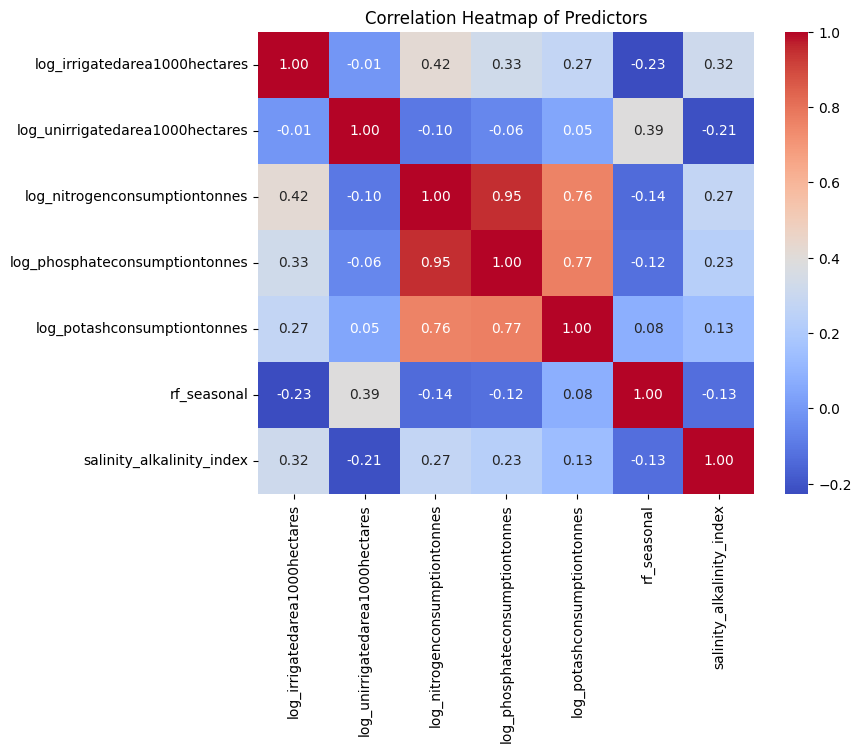

In [27]:
# Collinearity
X = rice_data[['log_irrigatedarea1000hectares', 'log_unirrigatedarea1000hectares','log_nitrogenconsumptiontonnes', 'log_phosphateconsumptiontonnes','log_potashconsumptiontonnes', 'rf_seasonal', 'salinity_alkalinity_index']]
corr_matrix = X.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Predictors")
plt.show()

In [28]:
X_vif = X  # Remove the constant column before calculating VIF

vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns

# Calculate VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Display VIF values
print(vif_data)


                           Feature         VIF
0    log_irrigatedarea1000hectares    3.617398
1  log_unirrigatedarea1000hectares    2.360493
2    log_nitrogenconsumptiontonnes  486.678422
3   log_phosphateconsumptiontonnes  507.906564
4      log_potashconsumptiontonnes   51.399260
5                      rf_seasonal    3.595462
6        salinity_alkalinity_index    1.576174


In [29]:
# Composite NPK index
rice_data['NPK_index'] = (
    rice_data['log_nitrogenconsumptiontonnes'] +
    rice_data['log_phosphateconsumptiontonnes'] +
    rice_data['log_potashconsumptiontonnes']
) / 3

y = rice_data['log_production1000tonnes']
X_new = rice_data[['log_irrigatedarea1000hectares',
          'log_unirrigatedarea1000hectares',
          'NPK_index',
          'rf_seasonal',
          'salinity_alkalinity_index']]
X_new = sm.add_constant(X_new)
model_A_no_corr = sm.OLS(y, X_new).fit()
print(model_A_no_corr.summary())

                               OLS Regression Results                               
Dep. Variable:     log_production1000tonnes   R-squared:                       0.846
Model:                                  OLS   Adj. R-squared:                  0.843
Method:                       Least Squares   F-statistic:                     286.2
Date:                      Wed, 25 Jun 2025   Prob (F-statistic):          1.69e-103
Time:                              12:00:45   Log-Likelihood:                -353.77
No. Observations:                       266   AIC:                             719.5
Df Residuals:                           260   BIC:                             741.0
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [30]:
X_vif = X_new.drop(columns='const')  # Remove the constant column before calculating VIF

vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns

# Calculate VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Display VIF values
print(vif_data)


                           Feature       VIF
0    log_irrigatedarea1000hectares  3.378714
1  log_unirrigatedarea1000hectares  2.330775
2                        NPK_index  5.983556
3                      rf_seasonal  3.406715
4        salinity_alkalinity_index  1.569253


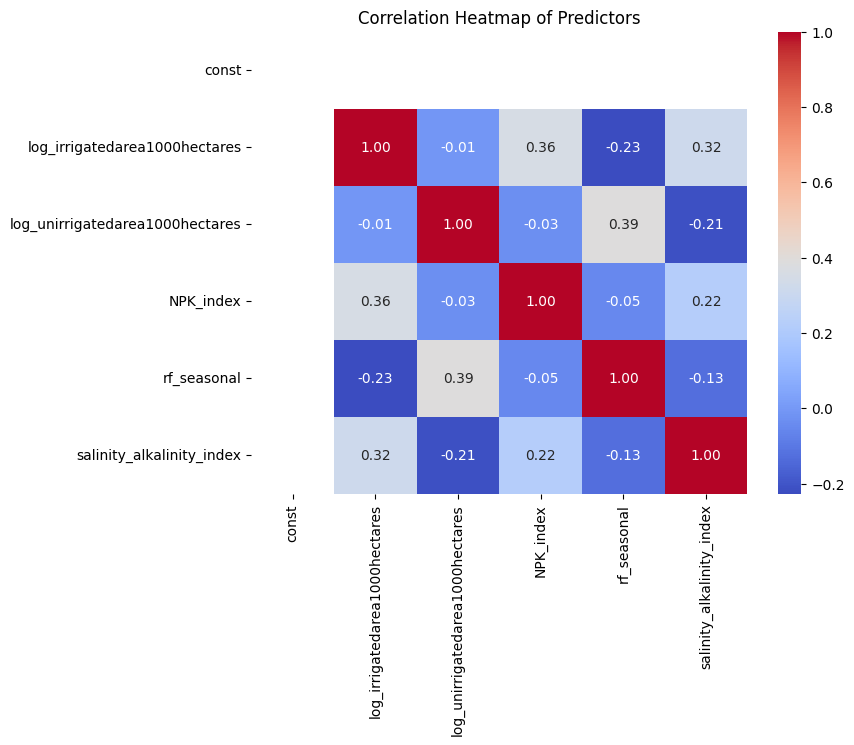

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(X_new.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Predictors")
plt.show()

# **4. Residual Diagnostics**

### **Strong Linear Relationship**
Crop production increases consistently with area, confirming the fundamental agricultural economic principle that **land is a primary factor of production**. The linear model assumption is reasonably supported.

### **Mild Heteroscedasticity Detected**
Slight increase in residual variance at higher area values reflects economic reality - **larger agricultural operations face greater production variability** due to scale complexities, weather exposure across extensive areas, and management challenges.

### **Approximately Normal Distribution**
Residuals center around zero with bell-shaped distribution, indicating the model captures most systematic relationships. **Sum of residuals = 0** confirms unbiased estimation - critical for valid economic inference.

### **Residuals Mostly Around Zero**
Good overall model fit with no major systematic patterns, suggesting **area explains substantial variation in production** across districts.

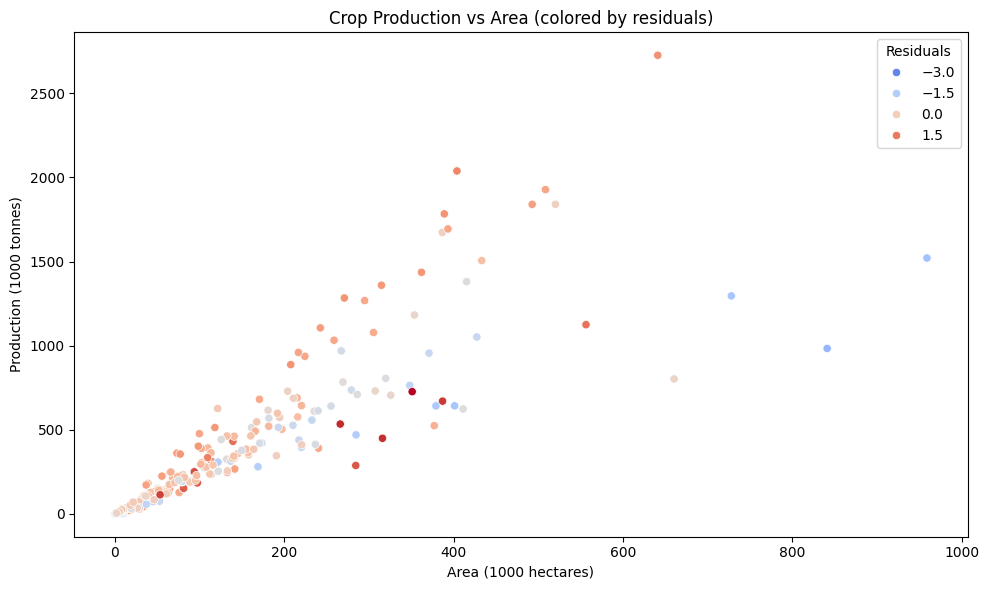

In [32]:
# Add residuals and predicted values to the DataFrame
rice_data['residuals'] = model_A.resid
rice_data['predicted'] = model_A.fittedvalues

# Plot 1: Production vs Area, color by residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='area1000hectares',
    y='production1000tonnes',
    hue='residuals',
    palette='coolwarm',
    data=rice_data
)
plt.title('Crop Production vs Area (colored by residuals)')
plt.xlabel('Area (1000 hectares)')
plt.ylabel('Production (1000 tonnes)')
plt.legend(title='Residuals')
plt.tight_layout()
plt.show()


Residuals vs Area plotting


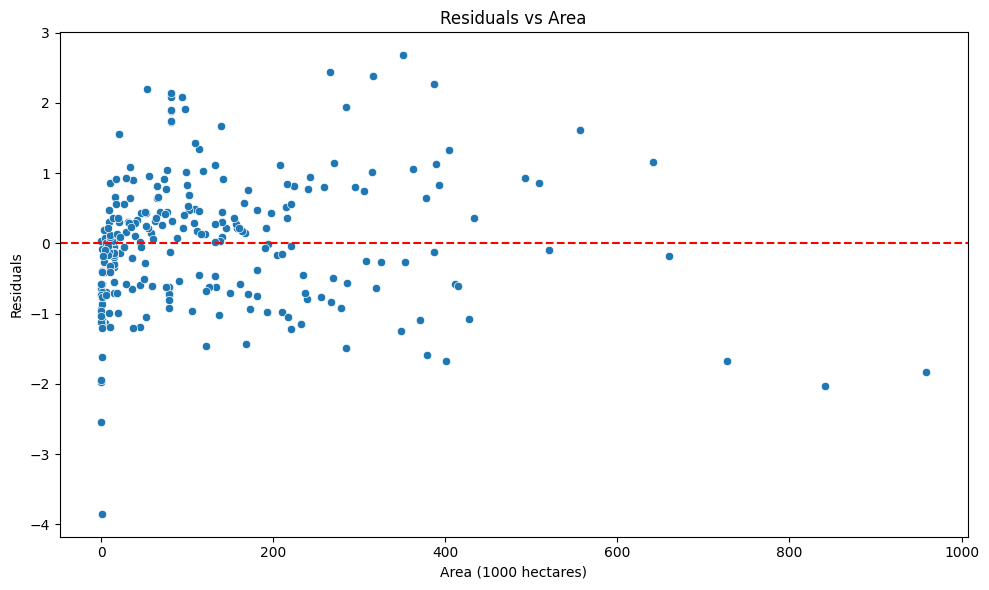

In [33]:
# Plot 2: Residuals vs Area
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='area1000hectares',
    y='residuals',
    data=rice_data
)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Area')
plt.xlabel('Area (1000 hectares)')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

Histogram of Residuals

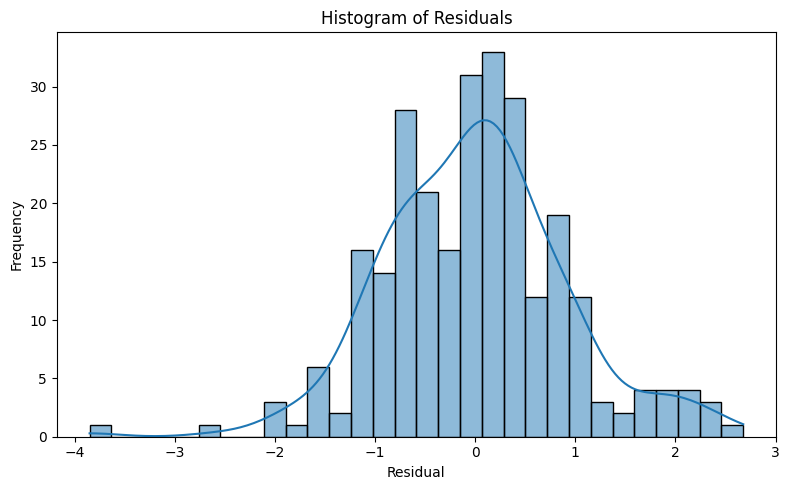

Sum of residuals: 0.0000


In [34]:
# Plot 3: Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(rice_data['residuals'], bins=30, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Check if the sum of residuals is approximately zero
residual_sum = rice_data['residuals'].sum()
print(f"Sum of residuals: {residual_sum:.4f}")

# **5. Returns to Scale Test: Farmer-Controlled Inputs**

Farmer-Controlled Inputs:
1. log_irrigatedarea1000hectares
2. log_unirrigatedarea1000hectares
3. log_nitrogenconsumptiontonnes
4. log_phosphateconsumptiontonnes
5. log_potashconsumptiontonnes

We’ll test whether the sum of their coefficients equals 1, which would imply constant returns to scale (CRS).

Hypotheses for Returns to Scale Test:

Null Hypothesis (H₀):
The production function exhibits constant returns to scale.

𝛽
1
+
𝛽
2
+
𝛽
3
+
𝛽
4
+
𝛽
5
= 1

Alternative Hypothesis (H₁):
The production function exhibits increasing or decreasing returns to scale.

𝛽
1
+
𝛽
2
+
𝛽
3
+
𝛽
4
+
𝛽
5
≠
1

In [35]:
model_A = smf.ols(formula, data=rice_data).fit()

# H0: sum of farmer-controlled input coefficients = 1
ftest = model_A.f_test(
    'log_irrigatedarea1000hectares + '
    'log_unirrigatedarea1000hectares + '
    'log_nitrogenconsumptiontonnes + '
    'log_phosphateconsumptiontonnes + '
    'log_potashconsumptiontonnes = 1'
)

# Print F-test result
print("\nF-test for constant returns to scale:")
print(ftest)


F-test for constant returns to scale:
<F test: F=46.88812935758752, p=5.4740803661611516e-11, df_denom=258, df_num=1>


Based on the F-test, we reject the null hypothesis of constant returns to scale at any conventional significance level (p < 0.01).
This provides strong statistical evidence that the production function exhibits non-constant returns to scale with respect to the inputs controlled by farmers.

The Cobb-Douglas production function does not exhibit constant returns to scale.
The sum of the input elasticities is approximately 1.37, indicating increasing returns to scale.
This suggests that a 1% increase in all farmer-controlled inputs leads to a more than 1% increase in output, on average.

# **6. Quadratic Production Function & Diminishing Marginal Returns**

## Quadratic Production Function

Building upon the Cobb-Douglas framework, we employed a quadratic production function to explore potential non-linear relationships between inputs and rice production more comprehensively. This approach allows for the assessment of diminishing or increasing returns to scale for individual inputs, potentially offering a more nuanced understanding of their impact on output.

**R-squared: 0.902**

**Adjusted R-squared: 0.898**

**F-statistic: 194.8 (p < 0.001)**

- High explanatory power (R-squared = 0.902) and overall model significance
- Diminishing returns for Unirrigated area
- Significant negative impact of salinity/alkalinity on production

## Hypothesis Testing for Diminishing Marginal Returns

**Hypothesis:**
- **Null Hypothesis:** The squared term coefficient is greater than or equal to zero (no diminishing marginal returns)
- **Alternative Hypothesis:** The squared term coefficient is less than zero (evidence of diminishing marginal returns)

**Results and Interpretation:**
- **Unirrigated area squared:**
  - Coefficient is significantly negative (p = 0.00032)
  - **Reject Null Hyp :** There is strong evidence of diminishing marginal returns to unirrigated land

- **All other squared terms (irrigated area, nitrogen, phosphate, potash):**
  - Coefficients are not significantly negative (p > 0.05)
  - **Fail to reject Null Hyp:** No strong evidence of diminishing marginal returns for these inputs

**Summary:**
Only unirrigated land shows statistically significant diminishing marginal returns, meaning that increasing unirrigated area leads to smaller incremental gains in output. For other inputs, there is no strong statistical evidence of diminishing marginal returns based on the one-sided t-tests.

### 6.1 Quadratic Production Function

In [36]:
rice_data['irrigated_sq'] = rice_data['irrigatedarea1000hectares'] ** 2
rice_data['unirrigated_sq'] = rice_data['unirrigatedarea1000hectares'] ** 2
rice_data['nitrogen_sq'] = rice_data['nitrogenconsumptiontonnes'] ** 2
rice_data['phosphate_sq'] = rice_data['phosphateconsumptiontonnes'] ** 2
rice_data['potash_sq'] = rice_data['potashconsumptiontonnes'] ** 2
##print(rice_data.columns.tolist())

In [37]:
# Quadratic regression model
quad_formula = (
    'production1000tonnes ~ '
    'irrigatedarea1000hectares + irrigated_sq + '
    'unirrigatedarea1000hectares + unirrigated_sq + '
    'nitrogenconsumptiontonnes + nitrogen_sq + '
    'phosphateconsumptiontonnes + phosphate_sq + '
    'potashconsumptiontonnes + potash_sq + '
    'rf_seasonal + salinity_alkalinity_index'
)

# Get the predictor variables from your quadratic formula
X_quad = rice_data[['irrigatedarea1000hectares', 'irrigated_sq',
                   'unirrigatedarea1000hectares', 'unirrigated_sq',
                   'nitrogenconsumptiontonnes', 'nitrogen_sq',
                   'phosphateconsumptiontonnes', 'phosphate_sq',
                   'potashconsumptiontonnes', 'potash_sq',
                   'rf_seasonal', 'salinity_alkalinity_index']]

X_quad = sm.add_constant(X_quad)


vif_data = pd.DataFrame()
vif_data["feature"] = X_quad.columns
vif_data["VIF"] = [variance_inflation_factor(X_quad.values, i) for i in range(X_quad.shape[1])]


print(vif_data)
print(" ")

model_b = smf.ols(formula=quad_formula, data=rice_data).fit()


print(model_b.summary())

                        feature        VIF
0                         const   7.530622
1     irrigatedarea1000hectares   9.568539
2                  irrigated_sq   8.528273
3   unirrigatedarea1000hectares   7.211322
4                unirrigated_sq   6.931853
5     nitrogenconsumptiontonnes  25.137082
6                   nitrogen_sq  15.900177
7    phosphateconsumptiontonnes  23.382106
8                  phosphate_sq  14.759321
9       potashconsumptiontonnes   7.095739
10                    potash_sq   5.007764
11                  rf_seasonal   1.293498
12    salinity_alkalinity_index   1.221739
 
                             OLS Regression Results                             
Dep. Variable:     production1000tonnes   R-squared:                       0.902
Model:                              OLS   Adj. R-squared:                  0.898
Method:                   Least Squares   F-statistic:                     194.8
Date:                  Wed, 25 Jun 2025   Prob (F-statistic):          2

### 6.2 Hypothese Testing: Diminishing Marginal Returns

In [38]:
print("\n=== One-sided t-tests for Diminishing Marginal Returns ===")
squared_terms = ['irrigated_sq', 'unirrigated_sq', 'nitrogen_sq', 'phosphate_sq', 'potash_sq']
df_resid = model_b.df_resid

for var in squared_terms:
    coef = model_b.params[var]
    std_err = model_b.bse[var]
    t_stat = (coef - 0) / std_err  # Null hypothesis: coef >= 0; test if coef < 0
    p_value = t.cdf(t_stat, df_resid)  # One-sided p-value for negative direction

    print(f"\n{var}:")
    print(f"  Coefficient = {coef:.5f}")
    print(f"  Std Error   = {std_err:.5f}")
    print(f"  t-Statistic = {t_stat:.3f}")
    print(f"  One-sided p-value (H1: coef < 0) = {p_value:.5f}")

    if p_value < 0.05:
        print("Reject H₀: Evidence of diminishing marginal returns.")
    else:
        print("Fail to reject H₀: No strong evidence of diminishing returns.")


=== One-sided t-tests for Diminishing Marginal Returns ===

irrigated_sq:
  Coefficient = 0.00045
  Std Error   = 0.00052
  t-Statistic = 0.866
  One-sided p-value (H1: coef < 0) = 0.80632
Fail to reject H₀: No strong evidence of diminishing returns.

unirrigated_sq:
  Coefficient = -0.00188
  Std Error   = 0.00054
  t-Statistic = -3.457
  One-sided p-value (H1: coef < 0) = 0.00032
Reject H₀: Evidence of diminishing marginal returns.

nitrogen_sq:
  Coefficient = 0.00000
  Std Error   = 0.00000
  t-Statistic = 2.481
  One-sided p-value (H1: coef < 0) = 0.99313
Fail to reject H₀: No strong evidence of diminishing returns.

phosphate_sq:
  Coefficient = -0.00000
  Std Error   = 0.00000
  t-Statistic = -1.415
  One-sided p-value (H1: coef < 0) = 0.07910
Fail to reject H₀: No strong evidence of diminishing returns.

potash_sq:
  Coefficient = -0.00000
  Std Error   = 0.00000
  t-Statistic = -0.070
  One-sided p-value (H1: coef < 0) = 0.47226
Fail to reject H₀: No strong evidence of dimini

# **7. Hypothesis Testing: Input Complementarity**



### **Individual Interaction Terms Analysis**

**One-sided t-tests for the following hypotheses:**

- **H₀:** Coefficient of interaction term ≤ 0 (No complementarity)
- **H₁:** Coefficient of interaction term > 0 (Evidence of complementarity)

| Input Pair | Coefficient | Std. Error | t-Statistic | One-sided p-value (H₁: coef > 0) | Conclusion |
|------------|-------------|------------|-------------|-----------------------------------|------------|
| irr_nit    | 0.00003     | 0          | 7.686       | 0                                | Reject H₀: Evidence of complementarity |
| irr_phos   | -0.00006    | 0.00001    | -6.504      | 1                                | Fail to reject H₀: No evidence |
| irr_pot    | 0.00004     | 0.00001    | 5.564       | 0                                | Reject H₀: Evidence of complementarity |

### **Joint F-test**

- **H₀:** coefficients of irr_nit, irr_phos, irr_pot = 0; i.e. no input complementarity
- **H₁:** The interaction terms do significantly improve model fit. (i.e., evidence of input complementarity — at least one coefficient ≠ 0)

| Model | df_resid | SSR (Sum of Squared Residuals) | df_diff | ss_diff | F-value | p-value | Conclusion |
|-------|----------|--------------------------------|---------|---------|---------|---------|------------|
| b     | 253      | 4.98E+06                      | —       | —       | —       | —       | Base model |
| c     | 250      | 3.85E+06                      | 3       | 1.13E+06| 24.39   | 7.03E-14| Model c fits significantly better |

### **Economic Interpretation**

**✓ Strong Evidence of Complementarity:**
- **Irrigation × Nitrogen**: Significant positive interaction (p ≈ 0)
- **Irrigation × Potash**: Significant positive interaction (p ≈ 0)
- **Joint F-test**: Highly significant (p = 7.03E-14)

**✗ No Evidence:**
- **Irrigation × Phosphate**: Negative coefficient, not significant for complementarity

**Summary:**
Strong statistical evidence that nitrogen and potash are more effective when combined with irrigation, confirming input complementarity hypothesis. The joint model significantly outperforms the base model, indicating that interaction effects are economically and statistically important in agricultural production.

Defining the new model:

In [40]:
full_formula = quad_formula + ' + irr_nit + irr_phos + irr_pot'
model_c = smf.ols(full_formula, data=rice_data).fit() # Fitting this interaction included term model

In [41]:
interaction_terms = ['irr_nit', 'irr_phos', 'irr_pot']
df_resid = model_c.df_resid

print("\n=== One-sided t-tests for Input Complementarity ===")
for term in interaction_terms:
    coef    = model_c.params[term]
    std_err = model_c.bse[term]
    t_stat  = (coef - 0) / std_err        # H0: coef <= 0; H1: coef > 0
    p_value = 1 - t.cdf(t_stat, df_resid)  # One-sided p-value for positive direction as we have to check for more effective
    print(f"\n{term}:")
    print(f"  Coefficient = {coef:.5f}")
    print(f"  Std Error   = {std_err:.5f}")
    print(f"  t-Statistic = {t_stat:.3f}")
    print(f"  One-sided p-value (H1: coef > 0) = {p_value:.5f}")

    if p_value < 0.05:
        print("Reject H₀: Evidence of input complementarity.")
    else:
        print("Fail to reject H₀: No strong evidence of complementarity.")


=== One-sided t-tests for Input Complementarity ===

irr_nit:
  Coefficient = 0.00003
  Std Error   = 0.00000
  t-Statistic = 7.686
  One-sided p-value (H1: coef > 0) = 0.00000
Reject H₀: Evidence of input complementarity.

irr_phos:
  Coefficient = -0.00006
  Std Error   = 0.00001
  t-Statistic = -6.504
  One-sided p-value (H1: coef > 0) = 1.00000
Fail to reject H₀: No strong evidence of complementarity.

irr_pot:
  Coefficient = 0.00004
  Std Error   = 0.00001
  t-Statistic = 5.564
  One-sided p-value (H1: coef > 0) = 0.00000
Reject H₀: Evidence of input complementarity.


Check if interaction of these terms matter as a group at all

Ho: B1 = B2 = B3 = 0, H1: B > 0

In [42]:
resVsNonRes = anova_lm(model_b, model_c)
print(resVsNonRes)

   df_resid           ssr  df_diff       ss_diff          F        Pr(>F)
0     253.0  4.977806e+06      0.0           NaN        NaN           NaN
1     250.0  3.850618e+06      3.0  1.127188e+06  24.394091  7.031062e-14



Lower is better: Model c’s SSR (3.85 M) is much smaller than Model b’s (4.98 M), meaning the full model fits better.

# **8.Enhancing Models: Regional Dummies**

https://www.rbi.org.in/upload/Publications/PDFs/58914.pdf the document for reference that we have used. 1 base case and 5 dummy variables.



### **Model Specification & Performance**

**Base Region:** South (used as reference group)

**Model 1:** Cobb-Douglas Production Function  
**Model 2:** Quadratic Production Function

**Quadratic outperforms Cobb-Douglas** in explaining variation in output due to inclusion of non-linear terms, with R-squared improving from 85.4% to 91.2%.

### **Economic Interpretation**

**✓ Consistent Regional Patterns:**
- **All regions (North, East, Central, North-East) show lower productivity** compared to the South, consistent across both models
- **Coefficients for most non-South dummies are negative and statistically significant**
- South emerges as the **most productive agricultural region** in India

**✓ Regional Productivity Ranking:**
1. **South** (reference, highest productivity)
2. **East** (positive in Cobb-Douglas, but negative in quadratic)
3. **West** (mixed performance)
4. **North** (consistently lower productivity)
5. **Central** (lowest productivity in both models)
6. **North-East** (moderate underperformance)

### **Model Enhancement Benefits**

**✓ Improved Model Fit:**
- **Lower VIF** in Model B reduces multicollinearity concerns
- **Higher R-squared** in quadratic model captures more variation
- **Greater flexibility** in capturing true input-output relationships

**✓ Regional Heterogeneity Captured:**
- Controls for **unobserved regional characteristics** (climate, soil, institutions)
- Provides **region-specific policy insights**
- Accounts for **geographical advantages/disadvantages**

**Summary:**
Regional dummies reveal significant **spatial heterogeneity** in agricultural productivity, with South India demonstrating superior performance. The enhanced models provide more accurate estimates by controlling for regional fixed effects, enabling targeted policy interventions for agricultural development across different zones of India.

In [43]:
#Creating region-wise mapping through a dictionary table

region_mapping_rbi = {
    'Chandigarh': 'North', 'Delhi': 'North', 'Haryana': 'North',
    'Himachal Pradesh': 'North', 'Jammu and Kashmir': 'North', 'Punjab': 'North',
    'Rajasthan': 'North', 'Uttar Pradesh': 'North',
    'Arunachal Pradesh': 'North_East', 'Assam': 'North_East', 'Manipur': 'North_East',
    'Meghalaya': 'North_East', 'Mizoram': 'North_East', 'Nagaland': 'North_East',
    'Tripura': 'North_East',
    'Andaman & Nicobar Islands': 'East', 'Bihar': 'East', 'Jharkhand': 'East',
    'Odisha': 'East', 'Sikkim': 'East', 'West Bengal': 'East',
    'Chhattisgarh': 'Central', 'Madhya Pradesh': 'Central',
    'Uttar Pradesh': 'Central', 'Uttarakhand': 'Central',
    'Dadra & Nagar Haveli': 'West', 'Daman & Diu': 'West', 'Goa': 'West',
    'Gujarat': 'West', 'Maharashtra': 'West',
    'Andhra Pradesh': 'South', 'Karnataka': 'South', 'Kerala': 'South',
    'Lakshadweep': 'South', 'Puducherry': 'South', 'Tamil Nadu': 'South', 'Telangana': 'South'
}

duplicate_cols = ['North','East', 'North_East', 'South', 'West', 'Central']

# Remove duplicate columns if they exist
for col in duplicate_cols:
    if col in rice_data.columns:
        rice_data = rice_data.drop(columns=[col])


rice_data['region_rbi'] = rice_data['statename'].map(region_mapping_rbi) # Creating the region column
region_dummies_rbi = pd.get_dummies(rice_data['region_rbi']) #Dropping Parent in this case
rice_data = pd.concat([rice_data, region_dummies_rbi], axis=1) #Adding to the table

rice_data[rice_data['region_rbi'] == 'Central']

,crop,area1000hectares,production1000tonnes,irrigatedarea1000hectares,districtcode,year,statecode,statename,nitrogenconsumptiontonnes,phosphateconsumptiontonnes,...,irr_nit,irr_phos,irr_pot,region_rbi,Central,East,North,North_East,South,West
0,Rice,841.13000,983.210020,353.733000,1,2017,14,Chhattisgarh,91447,53486,...,3.234782e+07,1.891976e+07,6.010985e+06,Central,True,False,False,False,False,False
1,Rice,660.35999,801.820010,33.077999,2,2017,14,Chhattisgarh,21279,12584,...,7.038667e+05,4.162535e+05,1.412761e+05,Central,True,False,False,False,False,False
2,Rice,959.01001,1520.950000,525.374020,3,2017,14,Chhattisgarh,92008,47721,...,4.833861e+07,2.507137e+07,7.908980e+06,Central,True,False,False,False,False,False
3,Rice,727.94000,1295.710000,400.825010,4,2017,14,Chhattisgarh,72926,29713,...,2.923056e+07,1.190971e+07,2.771705e+06,Central,True,False,False,False,False,False
4,Rice,411.12000,623.289980,54.150002,5,2017,14,Chhattisgarh,31282,13620,...,1.693920e+06,7.375230e+05,2.007341e+05,Central,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,Rice,19.59000,27.219999,4.420000,240,2017,16,Uttarakhand,86,45,...,3.801200e+02,1.989000e+02,8.840000e+00,Central,True,False,False,False,False,False
219,Rice,10.25000,17.570000,5.890000,241,2017,16,Uttarakhand,137,149,...,8.069300e+02,8.776100e+02,1.943700e+02,Central,True,False,False,False,False,False
220,Rice,10.41000,20.490000,7.710000,242,2017,16,Uttarakhand,75,33,...,5.782500e+02,2.544300e+02,1.542000e+01,Central,True,False,False,False,False,False
221,Rice,10.02000,13.870000,5.190000,243,2017,16,Uttarakhand,374,103,...,1.941060e+03,5.345700e+02,3.114000e+01,Central,True,False,False,False,False,False


In [44]:
quad_formula_with_regions_rbi = (
    quad_formula +  # Original quadratic formula
    ' + Q("North") + Q("East") + Q("West") + Q("Central") + Q("North_East")'  # RBI regional dummies
)


#Enhanced Model B
model_b_with_regions_rbi = smf.ols(formula=quad_formula_with_regions_rbi, data=rice_data).fit()

# Print summary
print(model_b_with_regions_rbi.summary())
print()

                             OLS Regression Results                             
Dep. Variable:     production1000tonnes   R-squared:                       0.912
Model:                              OLS   Adj. R-squared:                  0.906
Method:                   Least Squares   F-statistic:                     152.1
Date:                  Wed, 25 Jun 2025   Prob (F-statistic):          1.51e-120
Time:                          12:00:46   Log-Likelihood:                -1671.2
No. Observations:                   266   AIC:                             3378.
Df Residuals:                       248   BIC:                             3443.
Df Model:                            17                                         
Covariance Type:              nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

Now for Model A:

In [45]:
formula_with_regions_rbi = (
    'log_production1000tonnes ~ '
    'log_irrigatedarea1000hectares + '
    'log_unirrigatedarea1000hectares + '
    'log_nitrogenconsumptiontonnes + '
    'log_phosphateconsumptiontonnes + '
    'log_potashconsumptiontonnes + '
    'rf_seasonal + salinity_alkalinity_index + '
    'North + East + West + Central + North_East'  # Regional dummies
)

model_A_with_regions_rbi = smf.ols(formula=formula_with_regions_rbi, data=rice_data).fit()

# Print summary
print(model_A_with_regions_rbi.summary())

                               OLS Regression Results                               
Dep. Variable:     log_production1000tonnes   R-squared:                       0.854
Model:                                  OLS   Adj. R-squared:                  0.847
Method:                       Least Squares   F-statistic:                     123.5
Date:                      Wed, 25 Jun 2025   Prob (F-statistic):           2.23e-98
Time:                              12:00:46   Log-Likelihood:                -346.69
No. Observations:                       266   AIC:                             719.4
Df Residuals:                           253   BIC:                             766.0
Df Model:                                12                                         
Covariance Type:                  nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------